## Business Understanding

For this project a Convolutional Neural Network deep learning model was created for a proof of concept that would predict if a patient had lungs infected with pneumonia. The best model showed a high level of accuracy which would show the least number of results that are that would predict the patient does not have pneumonia when they actually do. Or in other words, are false negatives.

## Accessing the Data

Due to the number of images and the size of the dataset its recommended that it is downloaded to a folder and keras Image Data Generator and flow_from_directory methods are used to access it. The data can be downloaded from Keras [here](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).  The data will be downloaded as a .zip file and will require a program to access it.  Once opened exploration will reveal a number of redundant or empty files that contain much of the same data or no data at all such as MACOSX.  These files were deleted since they were considered unnessecessary.  The approach used for this project was to take the train, val, and test files from their parent folder and access them directly to expedite access and reduce the amount of code.  

## Data Description

 The data is pediatric X-ray images of lungs from 5863 patients. These images were split into three different sets: Train, Val, Test each containing subsets: Normal, and Pneumonia. This data took very little preperation since it was already split into training and validation sets.  The Val classes were small in comparison to the training data; as a result it was necessary to triple the number of samples by moving some of the images from the Train data folders to the Val folder.  This was done physically using the file explorer or finder on the local machine.  Due to a nearly three to one imbalance of images in the training data to images the target data SMOTE was used to better balance the data.  

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import keras as k
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Importing methods
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers
from focal_loss import BinaryFocalLoss
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, make_scorer, confusion_matrix

### Instantiating ImageDataGenerator and flow_from_directory

When instantiating the flow from directory method the color mode was changed to grayscale to expedite the processing of the data and class mode was set to binary since the model will be built to predict on discrete data. A loop is in clused after the Training Generator that is designed to create a weights that will help offset the low bias of the models and prevent overfitting.

In [2]:
# Make Training Generator

train_gen = ImageDataGenerator(rescale=1./256)
generate_train = train_gen.flow_from_directory(directory=r'../data/train', seed=42,
                                    color_mode='grayscale',
                                    target_size=(64, 64), 
                                    batch_size=50, 
                                    class_mode='binary',
                                    interpolation='nearest')

# This loop generates weights based on the classes in the
# training data
from collections import Counter
counter = Counter(generate_train.classes)                          
max_val = float(max(counter.values()))       
train_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}  

# Make Val Generator

val_gen = ImageDataGenerator(rescale=1./256)
generate_val = val_gen.flow_from_directory(directory=r'../data/val', seed=42,
                                   color_mode='grayscale',
                                   target_size=(64,64),
                                   batch_size=48, 
                                   class_mode='binary',
                                   interpolation='nearest')


# Maket Test Generator

test_gen = ImageDataGenerator(rescale=1./256)
generate_test = test_gen.flow_from_directory(directory=r'../data/test', seed=42,
                                   color_mode='grayscale',
                                   target_size=(64,64),
                                   batch_size=50, 
                                   class_mode='binary',
                                   interpolation='nearest')

Found 5184 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [3]:
# This code allow the models to continuously pull images from their respective directories.
train_image, train_label = next(generate_train)
test_image, test_label = next(generate_test)
val_image, val_label = next(generate_val)

In [4]:
import os
len(os.listdir('../data/train/NORMAL'))

1326

In [5]:
import os
len(os.listdir('../data/train/PNEUMONIA/'))

3860

##### As you can see above the training data and the target data have a nearly 3:1 ratio.  For this reason SMOTE will be applied to the training data.

In [4]:
sm = SMOTE(random_state=42, sampling_strategy='minority')

# SMOTE won't allow arrays with > 2 dimensions so images in train_image need to be resized
train_image_rsz = []
for i in range(len(train_image)):
    train_image_rsz.append(train_image[i].reshape(1,-1))
    
train_image_rsz = np.array(train_image_rsz).reshape(50, 4096)

In [5]:
train_image, train_label = sm.fit_resample(train_image_rsz, train_label)

###### This function will plot the loss and accuracy of the train and validation data after each model and assists in making meaning ful changes in the model by visualizing how accuracy and loss of ach function interacts

In [6]:

def plot_results(results):

    val_loss = results.history['val_loss']
    train_loss = results.history['loss']

    val_accuracy = results.history['val_accuracy']
    train_accuracy = results.history['accuracy']
    
    fig, ax = plt.subplots(1,2, figsize=(10,7))

    ax[0].plot(results.epoch, val_loss, c='b', label='val')
    ax[0].plot(results.epoch, train_loss, c='r', label='train')
    ax[0].legend()
    ax[0].set_title('Model Loss')

    ax[1].plot(results.epoch, val_accuracy, c='b', label='val')
    ax[1].plot(results.epoch, train_accuracy, c='r', label='train')
    ax[1].set_title('Model Accuracy')

    ax[1].legend() 

### The first simple model

It is important to note the model has a random seed set as the first line of code for reproducability and a few lines of code after for resizing the arrays being entered into the function.  Though SMOTE needed the data to be a 2-dimensional array the CNN models need a three dimensional array to be fed into the function.  It may also be noted that the class weight parameter in model.fit is set as the weight variable created earlier.

In [7]:
tf.random.set_seed(7)

train_image_inflate = []    
for i in range(len(train_image)):
    train_image_inflate.append(train_image[i].reshape(64,64,1))
train_image_inflate = np.array(train_image_inflate).reshape(76,64,64,1)

model = tf.keras.models.Sequential()

# Instantiating the model
model.add(Conv2D(10, 3, activation='relu', input_shape=(64,64,1), padding='same'))
model.add(MaxPooling2D(2,2))

model.add(k.layers.Flatten())
model.add(Dense(units=1, activation='sigmoid'))

# Compiler layer
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Fitting the model
results1 = model.fit(train_image_inflate, train_label, 
           validation_data=(val_image, val_label),
           class_weight=train_weights,
           epochs=10, 
           steps_per_epoch=5)


Epoch 1/10
5/5 [==============================] - 1s 111ms/step - loss: 1.2793 - accuracy: 0.4868 - val_loss: 0.9013 - val_accuracy: 0.5000
Epoch 2/10
5/5 [==============================] - 0s 43ms/step - loss: 1.1002 - accuracy: 0.5000 - val_loss: 0.7190 - val_accuracy: 0.5208
Epoch 3/10
5/5 [==============================] - 0s 53ms/step - loss: 0.9518 - accuracy: 0.5000 - val_loss: 0.8127 - val_accuracy: 0.5000
Epoch 4/10
5/5 [==============================] - 0s 54ms/step - loss: 0.8477 - accuracy: 0.5263 - val_loss: 0.6538 - val_accuracy: 0.5833
Epoch 5/10
5/5 [==============================] - 0s 41ms/step - loss: 0.7529 - accuracy: 0.6316 - val_loss: 0.6394 - val_accuracy: 0.6042
Epoch 6/10
5/5 [==============================] - 0s 56ms/step - loss: 0.6704 - accuracy: 0.6579 - val_loss: 0.6589 - val_accuracy: 0.6042
Epoch 7/10
5/5 [==============================] - 0s 55ms/step - loss: 0.5903 - accuracy: 0.7632 - val_loss: 0.5579 - val_accuracy: 0.7500
Epoch 8/10
5/5 [==========

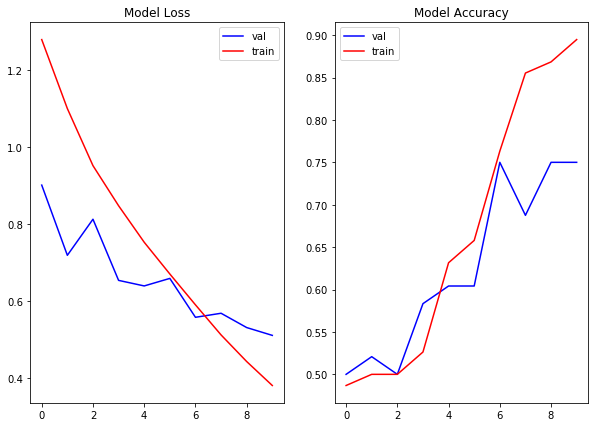

In [46]:
plot_results(results1)

In [13]:
model.evaluate(val_image, val_label)

2/2 [==============================] - 0s 4ms/step - loss: 0.5110 - accuracy: 0.7500


[0.5109569430351257, 0.75]

In [15]:
y_val_hat = model.predict_classes(val_image)

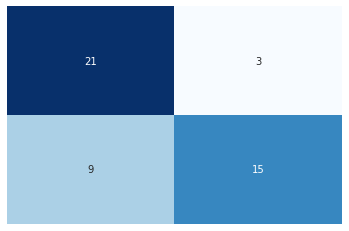

In [17]:
sns.heatmap(confusion_matrix(val_label, y_val_hat), annot=True, fmt='d',cmap='Blues', cbar=False,
           xticklabels=False, yticklabels=False,);

In [19]:
f1_score(val_label, y_val_hat)

0.7142857142857143

In [18]:
model.evaluate(test_image, test_label)

2/2 [==============================] - 0s 11ms/step - loss: 0.5285 - accuracy: 0.7600


[0.5285189747810364, 0.7599999904632568]

### Evaluation of FSM

Though the results of the model as tested by the validation and test scores show high accuracy ratings of .71 and .76 respectively the loss in both models is fairly high, above .5.  This is likely due to how the function checks against false negatives.  Since the data set was balanced by SMOTE, it is likely giving high penalizations to bad predictions causing a higher loss.  In addition to the high loss, the disproportionate performace by the training data as compared to the validation and test data show evidence of an overfit model.  This problem is usually caused by a model that is too complicated for the data it is working with.  In Convolutional Neural Networks this can be rectified by tuning the hyperparameters of the model.

### The Final model

In [18]:
tf.random.set_seed(7)

train_image_inflate = []    
for i in range(len(train_image)):
    train_image_inflate.append(train_image[i].reshape(64,64,1))
train_image_inflate = np.array(train_image_inflate).reshape(76,64,64,1)

model3 = tf.keras.models.Sequential()

# Da'model
model3.add(Conv2D(10, 3, activation='tanh', input_shape=(64,64,1), padding='same',
                  activity_regularizer=regularizers.l2(.0001))
model3.add(MaxPooling2D(2,2))

# Added Dropout layer
model3.add(Dropout(rate=.2))

# Added 
model3.add(Conv2D(20, 3, activation='tanh', padding='same',
                  activity_regularizer=regularizers.l2(.0001)))                
model3.add(MaxPooling2D(2,2))

model3.add(Conv2D(30, 3, activation='tanh', padding='same',
                  activity_regularizer=regularizers.l2(.0001)))                 
model3.add(MaxPooling2D(2,2))

model3.add(Conv2D(40, 3, activation='tanh', padding='same',
                  activity_regularizer=regularizers.l2(.0001)))
model3.add(MaxPooling2D(2,2))

model3.add(Conv2D(50, 3, activation='tanh', padding='same',
                  activity_regularizer=regularizers.l2(.0001)))
model3.add(MaxPooling2D(2,2))

model3.add(Conv2D(60, 3, activation='softmax', padding='same',
                  activity_regularizer=regularizers.l2(.0001)))
model3.add(k.layers.Flatten())

model3.add(Dense(units=1, activation='sigmoid'))

# Compiler layer
model3.compile(loss=BinaryFocalLoss(gamma=2),
               optimizer='Adam', 
               metrics=['accuracy'])
 
#Added early stopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-6, 
                           patience=1, verbose=0, mode='min')

# Fitting Da'model
results3 = model3.fit(train_image_inflate, train_label, 
                      epochs=30,
                      batch_size=10,
                      validation_data=(val_image, val_label),
                      class_weight=train_weights,                   
                      callbacks=[early_stop]) 

Epoch 1/30
8/8 [==============================] - 0s 51ms/step - loss: 3.3192 - accuracy: 0.4737 - val_loss: 0.9117 - val_accuracy: 0.5000
Epoch 2/30
8/8 [==============================] - 0s 23ms/step - loss: 1.0832 - accuracy: 0.5921 - val_loss: 1.2053 - val_accuracy: 0.5417
Epoch 3/30
8/8 [==============================] - 0s 28ms/step - loss: 0.6539 - accuracy: 0.8816 - val_loss: 0.7154 - val_accuracy: 0.6667
Epoch 4/30
8/8 [==============================] - 0s 31ms/step - loss: 0.5835 - accuracy: 0.8289 - val_loss: 0.8736 - val_accuracy: 0.6250
Epoch 5/30
8/8 [==============================] - 0s 27ms/step - loss: 0.5037 - accuracy: 0.8816 - val_loss: 0.6422 - val_accuracy: 0.7083
Epoch 6/30
8/8 [==============================] - 0s 23ms/step - loss: 0.3454 - accuracy: 0.9474 - val_loss: 0.6580 - val_accuracy: 0.7292
Epoch 7/30
8/8 [==============================] - 0s 26ms/step - loss: 0.3042 - accuracy: 0.9474 - val_loss: 0.6338 - val_accuracy: 0.7083
Epoch 8/30
8/8 [===========